‚è∞ √ñzellikleri belirtildiƒüinde ki≈üilerin diyabet hastasƒ± olup olmadƒ±klarƒ±nƒ± tahmin edebilecek bir makine √∂ƒürenmesi modeli geli≈ütirmek

‚öì Hedef deƒüi≈üken "outcome" 1 diyabet test sonucunun pozitif olu≈üunu 0 ise negatif olu≈üunu belirtmektedir.



‚è∞ Deƒüi≈ükenler

‚ñ∂ Pregnancies: Hamilelik sayƒ±sƒ±

‚ñ∂ Glucose: Glikoz.

‚ñ∂ BloodPressure: Kan basƒ±ncƒ±.

‚ñ∂ SkinThickness: Cilt Kalƒ±nlƒ±ƒüƒ±

‚ñ∂ Insulin: ƒ∞ns√ºlin.

‚ñ∂ BMI: Beden kitle indeksi.

‚ñ∂ DiabetesPedigreeFunction: Soyumuzdaki ki≈üilere g√∂re diyabet olma ihtimalimizi hesaplayan bir fonksiyon.

‚ñ∂ Age: Ya≈ü (yƒ±l)

‚ñ∂ Outcome: Ki≈üinin diyabet olup olmadƒ±ƒüƒ± bilgisi. Hastalƒ±ƒüa sahip (1) ya da deƒüil (0)

In [14]:
# kullanƒ±lacak k√ºt√ºphanelri ayarlayalƒ±m

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report # plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate


In [15]:
import sklearn.metrics

In [16]:
# kullanacaƒüƒ±mƒ±z bizim yazdƒ±ƒüƒ±mƒ±z fonksiyonlar
# e≈üik deƒüerleri hesaplamak  # √ßoƒüunlukla e≈üik deƒüer oranƒ± 0,25 -0,75 dir biz burada keskin bir tra≈ülama yapmƒ±yoruz
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [17]:
# aykƒ±rƒ± deƒüer var mƒ± yok mu ?
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [18]:
# aykƒ±rƒ± deƒüerlerin baskƒ±lanmasƒ±
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [19]:
# g√∂r√ºnt√º ayarlamalarƒ±nƒ± yapalƒ±m
pd.set_option("display.max_columns", None)
pd.set_option("Display.float_format", lambda x: "%.3f" %x)
pd.set_option("display.width", 500)

In [20]:
# veri setini okutup inceleyelim
df = pd.read_csv("/content/diabetes.csv")
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40             35      168 43.100                     2.288   33        1

In [21]:
df.shape

(768, 9)

In [22]:
# target analizi : outcome 1 ve 0 deƒüerlerinden olu≈üan bir kategorik deƒüi≈üken
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

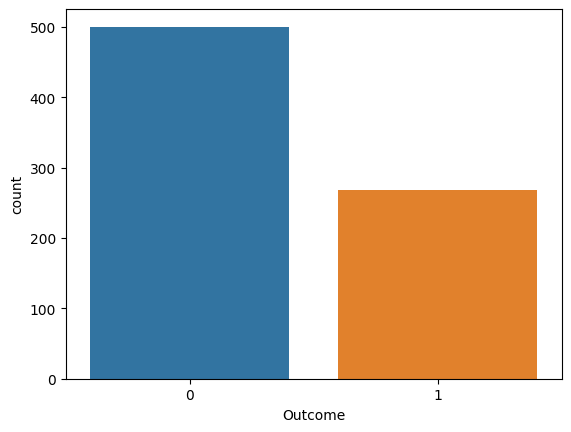

In [23]:
# ilgili deƒüerleri g√∂rselle≈ütirelim

sns.countplot(x="Outcome", data=df)
plt.show()

In [24]:
#ilgili daƒüƒ±lƒ±mƒ±n % olarak bulalƒ±m
df["Outcome"].value_counts()/ (len(df))*100

0   65.104
1   34.896
Name: Outcome, dtype: float64

In [25]:
# ya da
df["Outcome"].value_counts(normalize=True)*100

0   65.104
1   34.896
Name: Outcome, dtype: float64

üí£ FEATURE ANALƒ∞Zƒ∞

In [26]:
df.describe().T

count    mean     std    min    25%     50%     75%     max
Pregnancies              768.000   3.845   3.370  0.000  1.000   3.000   6.000  17.000
Glucose                  768.000 120.895  31.973  0.000 99.000 117.000 140.250 199.000
BloodPressure            768.000  69.105  19.356  0.000 62.000  72.000  80.000 122.000
SkinThickness            768.000  20.536  15.952  0.000  0.000  23.000  32.000  99.000
Insulin                  768.000  79.799 115.244  0.000  0.000  30.500 127.250 846.000
BMI                      768.000  31.993   7.884  0.000 27.300  32.000  36.600  67.100
DiabetesPedigreeFunction 768.000   0.472   0.331  0.078  0.244   0.372   0.626   2.420
Age                      768.000  33.241  11.760 21.000 24.000  29.000  41.000  81.000
Outcome                  768.000   0.349   0.477  0.000  0.000   0.000   1.000   1.000

In [27]:
# sayƒ±sal deƒüi≈ükenlerden bazƒ±larƒ±na histogram grafiklte inceleyelim
def plot_numerical_col(dataframe, numerical_col):
  dataframe[numerical_col].hist(bins=10)
  plt.xlabel(numerical_col)
  plt.show()



In [28]:
cols = [col for col in df.columns if "Outcome" not in col]  # target ƒ± grafikten √ßƒ±karalƒ±m

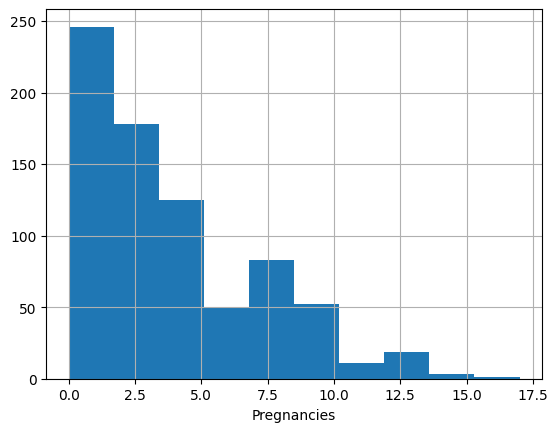

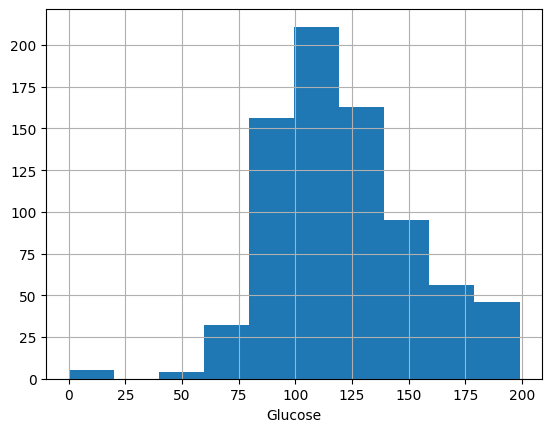

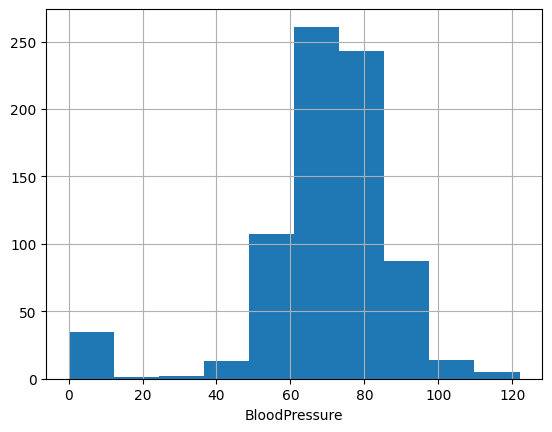

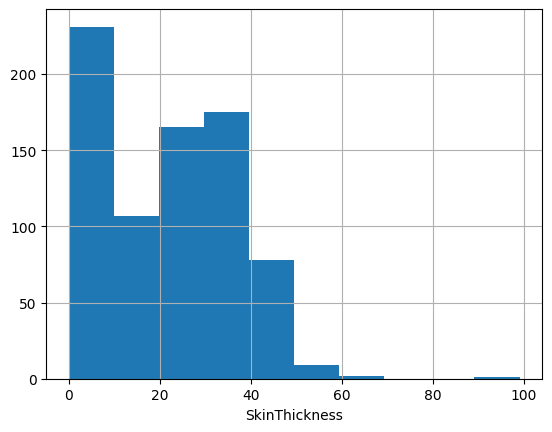

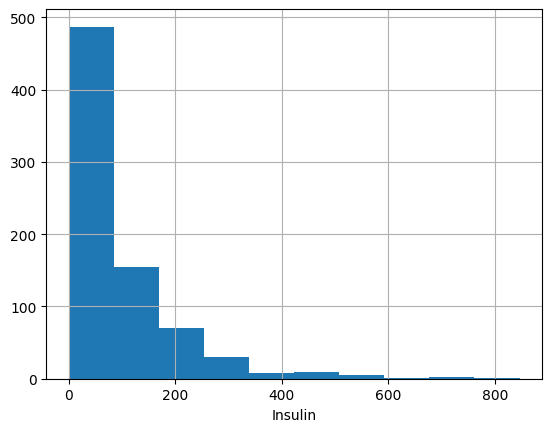

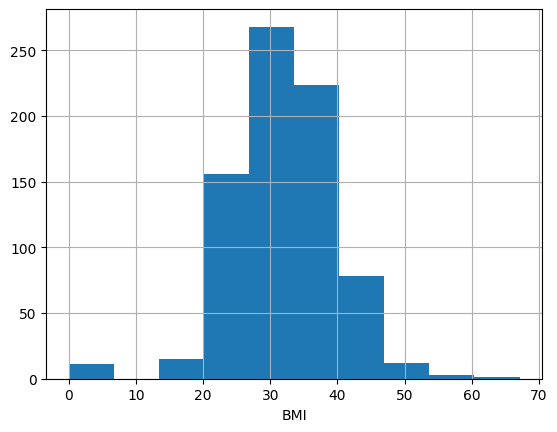

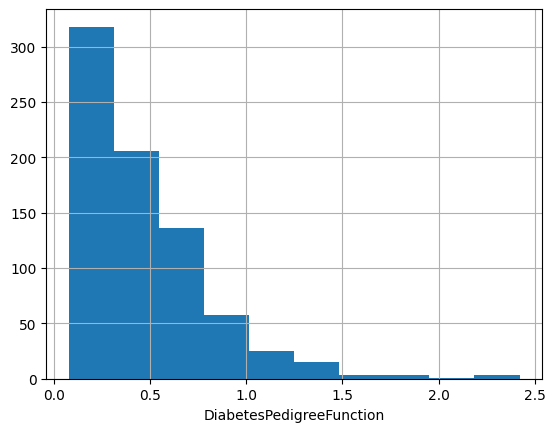

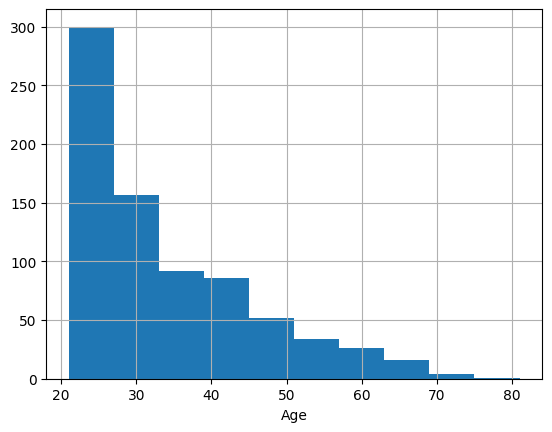

In [29]:
for col in cols:
  plot_numerical_col(df,col)


bu iki deƒüer incelendiƒüinde g√∂ze √ßarpan 0 deƒüerlerin olduƒüu ama canlƒ± insanƒ±n kan basƒ±ncƒ± ve/veya skinthickness deƒüeri 0 olamaz. Muhtemelen null deƒüerler 0 ile doldurulmu≈ü

In [30]:
# Target vs Features
df.groupby("Outcome").agg({"Pregnancies":"mean"})


Pregnancies
Outcome             
0              3.298
1              4.866

In [31]:
# target la ili≈ükiyi a√ßƒ±klayan bir fonksiyon tanƒ±mlayalƒ±m

def target_summary_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col: "mean"}))
  print("################################################")

In [32]:
for col in cols:
  target_summary_with_num(df, "Outcome",  col)

         Pregnancies
Outcome             
0              3.298
1              4.866
################################################
         Glucose
Outcome         
0        109.980
1        141.257
################################################
         BloodPressure
Outcome               
0               68.184
1               70.825
################################################
         SkinThickness
Outcome               
0               19.664
1               22.164
################################################
         Insulin
Outcome         
0         68.792
1        100.336
################################################
           BMI
Outcome       
0       30.304
1       35.143
################################################
         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550
################################################
           Age
Outcome       
0       31.190
1       37.0

 üé¥  VERƒ∞ √ñN ƒ∞≈ûLEME

In [33]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40             35      168 43.100                     2.288   33        1

In [34]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [35]:
df.describe().T

count    mean     std    min    25%     50%     75%     max
Pregnancies              768.000   3.845   3.370  0.000  1.000   3.000   6.000  17.000
Glucose                  768.000 120.895  31.973  0.000 99.000 117.000 140.250 199.000
BloodPressure            768.000  69.105  19.356  0.000 62.000  72.000  80.000 122.000
SkinThickness            768.000  20.536  15.952  0.000  0.000  23.000  32.000  99.000
Insulin                  768.000  79.799 115.244  0.000  0.000  30.500 127.250 846.000
BMI                      768.000  31.993   7.884  0.000 27.300  32.000  36.600  67.100
DiabetesPedigreeFunction 768.000   0.472   0.331  0.078  0.244   0.372   0.626   2.420
Age                      768.000  33.241  11.760 21.000 24.000  29.000  41.000  81.000
Outcome                  768.000   0.349   0.477  0.000  0.000   0.000   1.000   1.000

In [36]:
# aykƒ±rƒ± deƒüer var mƒ± yok mu bakalƒ±m
for col in cols:
  print(col, check_outlier(df, col))   # sadece insulinde aykƒ±rƒ±lƒ±k  var g√∂r√ºn√ºyor

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [37]:
replace_with_thresholds(df, "Insulin")

In [38]:
for col in cols:
  print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [39]:
#standartla≈ütƒ±rma yapalƒ±m  robustscaler b√ºt√ºn g√∂zlemlerin deƒüerinden medyanƒ± √ßƒ±karƒ±p range deƒüerine b√∂l√ºyor
#standarScaler dan farkƒ± aykƒ±rƒ± deƒüerlerden etkilenmiyor

for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

In [40]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age  Outcome
0        0.600    0.752          0.000          0.375   -0.240  0.172                     0.665  1.235        1
1       -0.400   -0.776         -0.333          0.188   -0.240 -0.581                    -0.056  0.118        0
2        1.000    1.600         -0.444         -0.719   -0.240 -0.935                     0.783  0.176        1
3       -0.400   -0.679         -0.333          0.000    0.499 -0.419                    -0.537 -0.471        0
4       -0.600    0.485         -1.778          0.375    1.081  1.194                     5.008  0.235        1

üêó
‚õπ
üí£
 MODELLEME



In [41]:
# baƒüƒ±mlƒ± deƒüi≈üken y ile kalanlar x  ile
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [42]:
X.shape

(768, 8)

In [43]:
y.shape

(768,)

In [44]:
log_model = LogisticRegression().fit(X, y)

In [45]:
# bu modelin sabitlerine bakalƒ±m b deƒüeri
log_model.intercept_[0]

-1.2343958783485596

In [46]:
# W deƒüerleri 8 ayrƒ± bile≈üen i√ßin
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [47]:
# modele X ( baƒüƒ±msƒ±z deƒüi≈ükenleri ) verelim ve ondan y_tshminleri alalƒ±m
y_pred = log_model.predict(X)

In [48]:
y[:5]

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [49]:
y_pred[:5]  # ilk 5 deƒüer i√ßin doƒüru tahmin edilmi≈ü. ≈ûimdi t√ºm verileri kƒ±yaslayarak modelimizin ba≈üarƒ±sƒ±nƒ± bulalƒ±m

array([1, 0, 1, 0, 1])

**üß≤  MODEL BA≈ûARI DEƒûERLENDƒ∞RMESƒ∞**

In [50]:
# confision matrix i g√∂rselle≈ütrecek fonksiyon yazalƒ±m
def plot_confusion_matrix(y, y_pred):
  acc = round(accuracy_score(y, y_pred), 2)  # acuracy : doƒüru sƒ±nƒ±flandƒ±rma oranƒ±
  cm = confusion_matrix(y, y_pred)  #
  sns.heatmap(cm, annot=True, fmt=".0f")
  plt.xlabel("y_pred")
  plt.ylabel("y")
  plt.title("Accuracy Score : {0}".format(acc), size=10)
  plt.show()

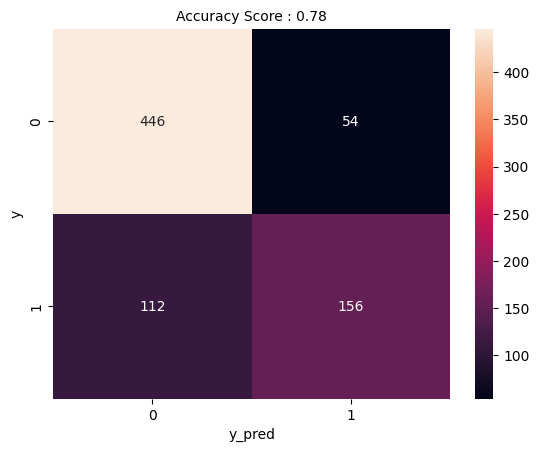

In [51]:
# fonksiyonu modelimizde deneyelim
plot_confusion_matrix(y, y_pred)

In [52]:
print(classification_report(y, y_pred))

# 1 olarak yaptƒ±ƒüƒ±mƒ±z tahminlerin % 74 √º ba≈üarƒ±lƒ±
# recall 1 olanlarƒ± %58 ba≈üarƒ±yla doƒüru sƒ±nƒ±flandƒ±rdƒ±k

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [53]:
# farklƒ± thresoldlara g√∂re olu≈üan metrik
y_prob = log_model.predict_proba(X)[:,1]


In [54]:
roc_auc_score(y, y_prob)

0.8393955223880598

In [55]:
# modeli kurduƒüumuz veride yine modeli  test ettik


üß≤ MODEL DOƒûRULAMA

holdout y√∂ntemiyle veriyi 2 ye b√∂leceƒüin train ve test olarak

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)  # random state i aynƒ± sonu√ßlarƒ± almak i√ßin kullandƒ±k yani aynƒ± %20 dilimde aynƒ± veriler olacak

In [57]:
# train setinde modelimizi kuralƒ±m
log_model = LogisticRegression().fit(X_train, y_train)

In [58]:
# kurduƒüummuz modele modelin g√∂rmediƒüi %20 lik x_test veri setini sorup tahminleri alalƒ±m
y_pred = log_model.predict(X_test)

In [59]:
# 1 sƒ±nƒ±fƒ±na ait olma olasƒ±lƒ±klarƒ±nƒ± hesaplayalƒ±m
y_prob = log_model.predict_proba(X_test)[:, 1]

In [60]:
y_prob[5]   # olasƒ±lƒ±k tahminlerinden biri

0.43013794157012986

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



In [62]:
from sklearn.metrics import RocCurveDisplay


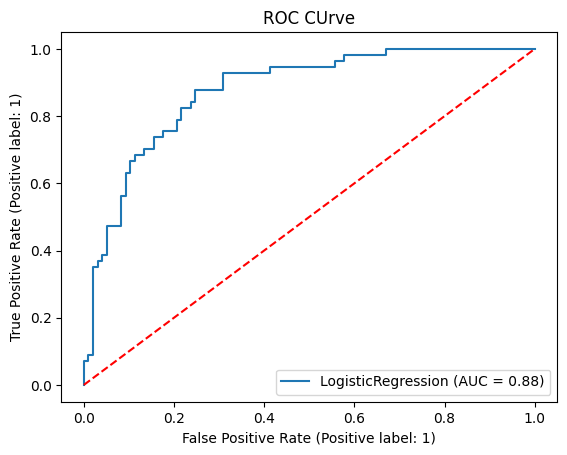

In [66]:
#  model ba≈üarƒ±sƒ± ile ilgili grafik √ßizelim
# RocCurveDisplay.from_estimator(log_model, X_test, y_test)
plt.title("ROC CUrve")
plt.plot([0,1], [0,1],"r--")
plt.show()

daha √∂nceki auc deƒüeri 0,83 d√º ≈üimdiki modelde 0.88

üí£ üí£ üí£

**10 katlƒ± √ßapraz doƒürulama **

In [67]:
# veri seti √ßok fazla veriden olu≈ümuyor o y√ºzden b√ºt√ºn veriyi kullanarak i≈ülem yapalƒ±m
log_model = LogisticRegression().fit(X,y)

In [68]:
# 5 katlƒ± yapalƒ±m
cv = cross_validate(log_model, X, y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [69]:
cv["test_accuracy"].mean()

0.7721925133689839

In [72]:
cv

{'fit_time': array([0.01019835, 0.00565076, 0.00533724, 0.0054841 , 0.00575447]),
 'score_time': array([0.01218104, 0.00935864, 0.01037145, 0.00948787, 0.00961709]),
 'test_accuracy': array([0.77272727, 0.74675325, 0.75324675, 0.81699346, 0.77124183]),
 'test_precision': array([0.71111111, 0.64705882, 0.71052632, 0.79069767, 0.73684211]),
 'test_recall': array([0.59259259, 0.61111111, 0.5       , 0.64150943, 0.52830189]),
 'test_f1': array([0.64646465, 0.62857143, 0.58695652, 0.70833333, 0.61538462]),
 'test_roc_auc': array([0.81277778, 0.80888889, 0.825     , 0.87339623, 0.84358491])}

daha √∂nceki sonu√ßlara bakalƒ±m ‚Åâ

Accuracy: 0.78
Precision: 0.74
Recall: 0.58
F1-score: 0.65



Accuracy: 0.77
Precision: 0.79
Recall: 0.53
F1-score: 0.63



son i≈ülemin ortalamalarƒ±
accuracy :0.7721
precision: 0.7192
recall : 0.5747
f1 : 0.63
